# Assignment ESM Module - Renewable Energy Droughts

In this final assignment for the Energy System Modelling module, you will first look into the concept of Renewable Energy Droughts and then you will have the opportunity to pose and answer an energy system related research question of your choosing. You will use the skills you learned in the previous tutorials, but you will also need to use packages/functions that have not been introduced in the tutorials. Hence, you will need to look up the documentation of relevant Python packages, and use Google/Stack Overflow/ChatGPT to find solutions to the problems you will encounter. Follow the steps below.

## Exercise 1 - ERA5 data download and merge

In this assignment, we will again use the ERA5 Reanalysis dataset and a vector map of NUTS regions. You can use the same NUTS map that you downloaded in the tutorials. For the ERA5 dataset, we provide you with a file including a six-month period (1 July 2022 - 31 Dec 2022) with a **three-hourly** time resolution. This dataset contains the variables **'ssrd',  'u100', 'v100' and 't2m'** for mainland Europe, using the following coordinates (same as in the tutorials):

north = 71.22
south = 34.31
east = 51.29
west = -23.62

The above 4 variables are needed to later create time series for solar and wind energy production. Your first task is to complement this dataset by downloading the data for the period between 1 January 2022 - 30 June 2022. Consider the same variable sets, time resolution and coordinates as with the provided data. 

After downloading the data, merge the downloaded ERA5 dataset with the provided ERA5 dataset to create one single xarray array, containing data for all days of 2022. Please provide the code you have used as well as a concise summary of the data set variables and attributes using xarray.Dataset.info.


In [5]:
# # We start by importing the given datasets:
# # We download the dataset:
# We go to https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download
# https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference
# And generate the following API call:

# VE: we use a simple boolean flag to avoid redownloading the dataset when running the whole notebook.
should_import = False 

if should_import: 
    import cdsapi
    
    dataset = "reanalysis-era5-single-levels"
    request = {
    "product_type": ["reanalysis"],
    "variable": [
    "2m_temperature",
    "100m_u_component_of_wind",
    "100m_v_component_of_wind",
    "surface_solar_radiation_downwards"
    ],
    "year": ["2022"],
    "month": [
    "01", "02", "03",
    "04", "05", "06"
    ],
    "day": [
    "01", "02", "03",
    "04", "05", "06",
    "07", "08", "09",
    "10", "11", "12",
    "13", "14", "15",
    "16", "17", "18",
    "19", "20", "21",
    "22", "23", "24",
    "25", "26", "27",
    "28", "29", "30",
    "31"
    ],
    "time": [
    "00:00", "03:00", "06:00",
    "09:00", "12:00", "15:00",
    "18:00", "21:00"
    ],
    "data_format": "netcdf",
    "download_format": "zip",
    "area": [71.22, -23.62, 34.31, 51.29]
    }

    client = cdsapi.Client()
    client.retrieve(dataset, request).download()




We unzip the file - not done in the notebook

In [6]:
# VE: Importing all datasets

import xarray as xr

ds1 = xr.open_dataset('data/SSRD_data_stream-oper_stepType-accum.nc')

ds2 = xr.open_dataset('data/Wind_T_data_stream-oper_stepType-instant(1).nc')

ds3 = xr.open_dataset('data/2fd37c9d9398827e76de2fb9731e405f/data_stream-oper_stepType-accum.nc')

ds4 = xr.open_dataset('data/2fd37c9d9398827e76de2fb9731e405f/data_stream-oper_stepType-instant.nc')


print(ds1.data_vars) # ssrd only
print(ds2.data_vars) # t2m, u100, v100
print(ds3.data_vars) # ssrd
print(ds4.data_vars) #t2m, u100, v100

Data variables:
    ssrd     (valid_time, latitude, longitude) float32 261MB ...
Data variables:
    t2m      (valid_time, latitude, longitude) float32 261MB ...
    u100     (valid_time, latitude, longitude) float32 261MB ...
    v100     (valid_time, latitude, longitude) float32 261MB ...
Data variables:
    ssrd     (valid_time, latitude, longitude) float32 257MB ...
Data variables:
    t2m      (valid_time, latitude, longitude) float32 257MB ...
    u100     (valid_time, latitude, longitude) float32 257MB ...
    v100     (valid_time, latitude, longitude) float32 257MB ...


In [7]:
# VE: perform merge, failing loudly if there are conflicts.
ds_jan_june = xr.merge([ds1, ds2], join="outer", compat="identical")
ds_jul_dec = xr.merge([ds3, ds4], join="outer", compat="identical")

In [8]:
# VE: concatenation by time (this takes a while)
ds_final = xr.concat([ds_jan_june, ds_jul_dec], dim="valid_time")



Text(0.5, 1.0, 'time-averaged temperature (2022)')

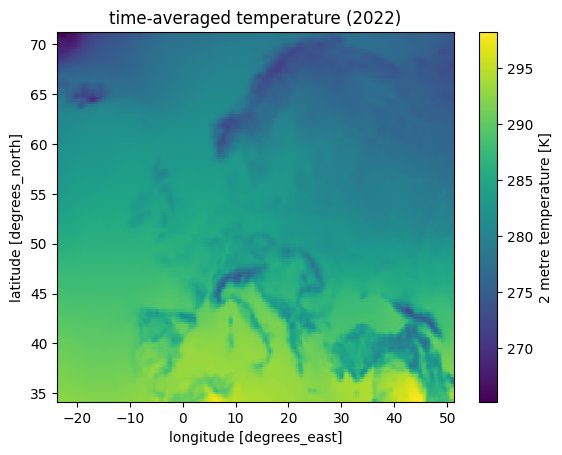

In [9]:
# let's map ssrd and t2m for our data:
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots()

ds_final.mean(dim='valid_time')['t2m'].plot()

ax.set_title("time-averaged temperature (2022)")

Text(0.5, 1.0, 'time-averaged radiation (2022)')

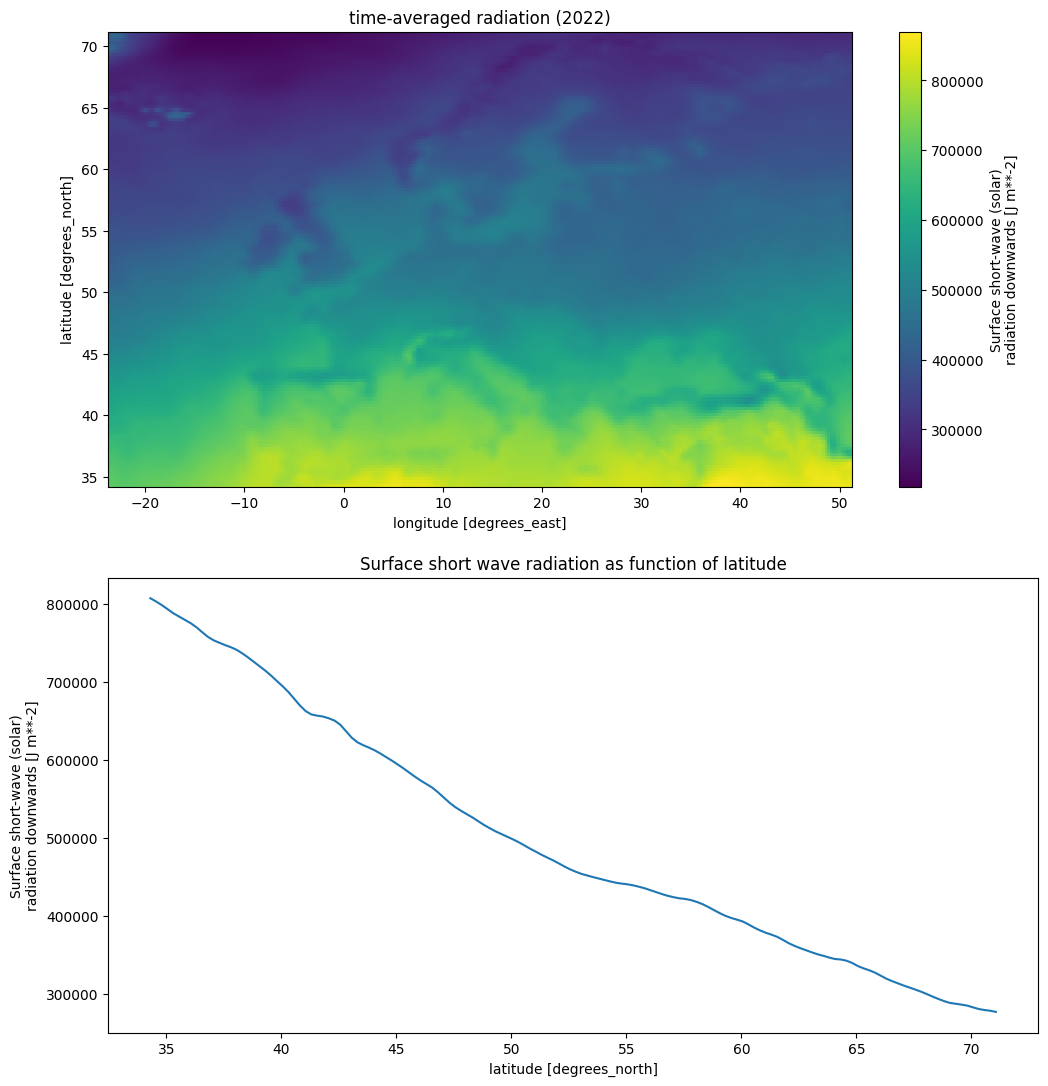

In [21]:
# let's map ssrd and t2m for our data:
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots(2,1, figsize=(12,13))

ds_final.mean(dim='valid_time')['ssrd'].plot(ax=ax[0])


ds_final["ssrd"].mean(dim=["longitude", "valid_time"]).plot.line(ax=ax[1])

ax[1].set_title("Surface short wave radiation as function of latitude")

ax[0].set_title("time-averaged radiation (2022)")

In [4]:
# do a geo-map of the dataset. 

In [60]:
# xarray.merge for the two tutorials
# xarray.concat. 

# we confirm that the final dataset has the size 2920 x 148 x 300

# we expect to have 3 dimensions:
ds_final.dims


FrozenMappingWarningOnValuesAccess({'valid_time': 2920, 'latitude': 148, 'longitude': 300})

In [62]:
# labelled by 
# 3 coordinates (3 dimensioned coordinates)
ds_final.coords

Coordinates:
  * valid_time  (valid_time) datetime64[ns] 23kB 2022-07-01 ... 2022-06-30T21...
  * latitude    (latitude) float64 1kB 71.06 70.81 70.56 ... 34.81 34.56 34.31
  * longitude   (longitude) float64 2kB -23.62 -23.37 -23.12 ... 50.88 51.13
    number      int64 8B 0
    expver      (valid_time) <U4 47kB '0001' '0001' '0001' ... '0001' '0001'

In [63]:
# variable ssrd:

ds_final['ssrd']

<xarray.DataArray 'ssrd' (valid_time: 2920, latitude: 148, longitude: 300)> Size: 519MB
array([[[8.9868000e+04, 8.9900000e+04, 8.6072000e+04, ...,
         7.3112000e+04, 7.4352000e+04, 7.7372000e+04],
        [8.4680000e+04, 8.3836000e+04, 8.2448000e+04, ...,
         6.5912000e+04, 7.5340000e+04, 8.2860000e+04],
        [7.1332000e+04, 6.9804000e+04, 6.8768000e+04, ...,
         6.9364000e+04, 8.1412000e+04, 9.4440000e+04],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[5.4560000e+04, 5.5712000e+04, 5.4208000e+04, ...,
         2.0675200e+05, 2.0473600e+05, 2.0342400e+05],
        [5.4496000e+04, 5.5488000e+04, 5.5904000e+04, ...,
         1.7968000e+05, 1.8121600e+05, 1.8179200e+05],
        [4.7680000e+04, 4.8640000e+04, 4.9376000e+04, ...,
         1.7417600e+05, 1.7606400e+05, 1.7843200e+05],
...
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.5571840e+06, 1.5429760e+06, 1.4995200e+06, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.6003840e+06, 1.5769600e+06, 1.5205760e+06, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[3.0955200e+05, 3.0152000e+05, 2.8102400e+05, ...,
         5.0464000e+04, 5.9296000e+04, 6.8304000e+04],
        [3.0097600e+05, 2.9116800e+05, 2.8171200e+05, ...,
         5.6928000e+04, 6.3632000e+04, 7.1232000e+04],
        [2.6278400e+05, 2.5140800e+05, 2.4315200e+05, ...,
         6.2336000e+04, 6.8016000e+04, 7.3680000e+04],
        ...,
        [9.4416000e+04, 8.2688000e+04, 7.4736000e+04, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [8.1552000e+04, 7.1200000e+04, 6.3968000e+04, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [6.8400000e+04, 5.9408000e+04, 5.4368000e+04, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]],
      shape=(2920, 148, 300), dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 23kB 2022-07-01 ... 2022-06-30T21...
  * latitude    (latitude) float64 1kB 71.06 70.81 70.56 ... 34.81 34.56 34.31
  * longitude   (longitude) float64 2kB -23.62 -23.37 -23.12 ... 50.88 51.13
    number      int64 8B 0
    expver      (valid_time) <U4 47kB '0001' '0001' '0001' ... '0001' '0001'
Attributes: (12/32)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      44400
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...
    GRIB_surface:                             0.0

## Exercise 2 - Determining solar and wind power capacity factors

The weather data in the ERA5 dataset can be used to estimate the capacity factors for wind turbines and solar photovoltaic (PV) panels. The capacity factor be defined as follows: "The ratio of the electrical energy produced by a generating unit for the period of time considered to the electrical energy that could have been produced at continuous full power operation during the same period." [(EIA)](https://www.eia.gov/tools/glossary/index.php?id=Capacity_factor#:~:text=Capacity%20factor%3A%20The%20ratio%20of,operation%20during%20the%20same%20period.)

The capacity factor of a PV panel can be estimated using the downwards surface solar radiation and the temperature. Using the data from the ERA5 dataset, we will add the variable 'cf_pv' to the era5 xarray array, which shows the capacity factor for each grid cell and for each 3-hour timestep. To do so, you need to use the following function, based on the supplementary material of [Brown, Farnham and Caldeira (2021)](https://doi.org/10.1007/s42452-021-04794-z):

In [32]:
import numpy as np
def calculate_pv_cf(data):
    ghi_wh = (data['ssrd'] / 3600)
    Tmod = (data['t2m'] - 273.15) + (28 * (ghi_wh/800))
    deltaTmod = Tmod - (25)
    G_tilde = ghi_wh/1000 

    nrel = (1 + (0.0012 * deltaTmod)) *\
        (1 + (0.033 * np.log(G_tilde)) +\
         (-0.0092 * (np.log(G_tilde)**2)) +\
             (-0.0046 * deltaTmod))
    pv_cf = nrel * (ghi_wh / 1000)
    pv_cf=pv_cf.fillna(0)
    return pv_cf

In [33]:


type(ds_final['ssrd']) #xarray.core.dataarray.DataArray



xarray.core.dataarray.DataArray

In [34]:
#insert code to determine capacity factors for pv systems using the ERA5 dataset


#hint1: call the function defined above
#hint2: add a new variable, called 'cf_pv' to the era5 xarray array
ds_final["cf_pv"]  = calculate_pv_cf(ds_final)
print(f"the mean capacity factor is {ds_final["cf_pv"].mean().item()}")

# note the divide by zero error below is not an issue because we are multiplying the result by gwhi = 0, yielding zero

/Users/victorelgersma/dev/DAFS/.venv/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


the mean capacity factor is 0.12852682173252106


In [35]:
type(ds_final['ssrd'])

xarray.core.dataarray.DataArray

Text(0.5, 1.0, 'time-averaged solar capacity factor (2022)')

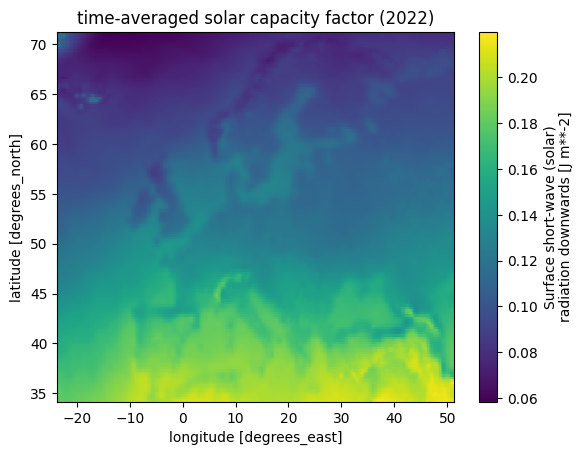

In [36]:
# let's map cf_pv
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots()

ds_final.mean(dim='valid_time')['cf_pv'].plot()

ax.set_title("time-averaged solar capacity factor (2022)")

In [82]:
# Check that a new 'var' has been added:



ds_final['ssrd'].coords

ds_final['ssrd'].dims


('valid_time', 'latitude', 'longitude')

To determine the capacity factor of wind turbines, we consider a simplified power curve of a wind turbine. A power curve shows the power output of a wind turbine at specific wind speeds. You will use the following power curve in your analysis:

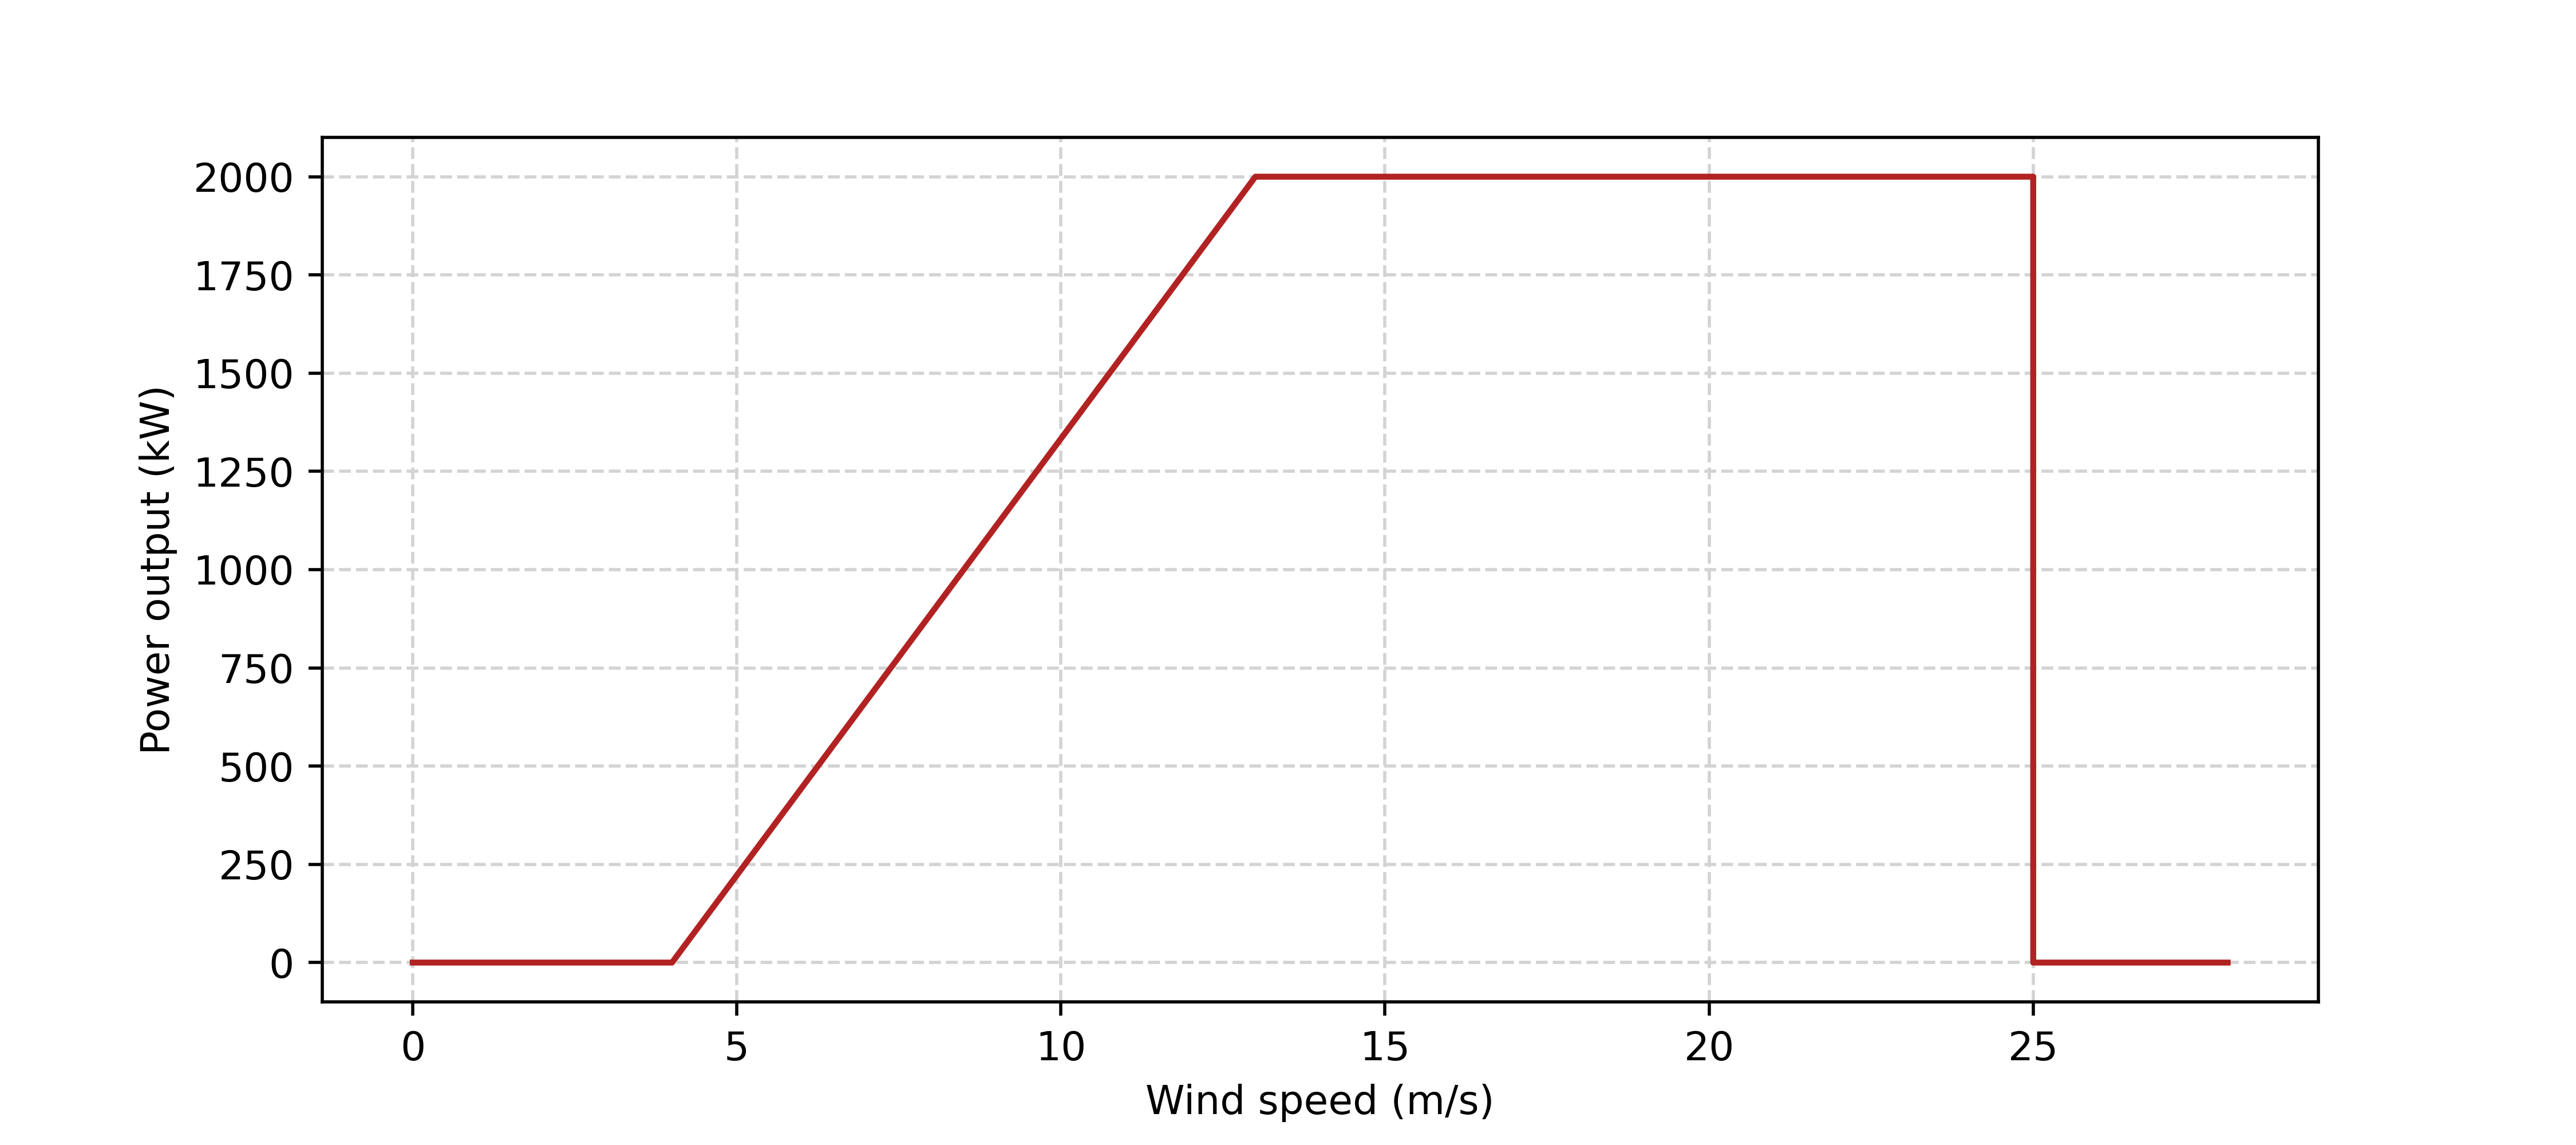

The considered turbine has a cut-in wind speed of 4 m/s, a rated wind speed of 13 m/s, a cut-out wind speed of 25 m/s and a rated capacity of 2 MW. This means that at wind speeds below 4 m/s and above 25 m/s, there is no power output. Between 4 and 13 m/s, we assume for simplicity that the power output increases linearly from 0 to its rated capacity. At wind speeds between 13 m/s and 25 m/s, the power output equals the rated capacity.

Your next task will be to add a new variable 'cf_wind' in the era5 xarray array, portraying the capacity factor for wind turbines for each grid cell and each 3-hour timestep using the above power curve. To do this, create a function to convert the wind speed in the era5 xarray array to wind power. Some tips:
1. Take a look at the provided function to determine the capacity factors for solar PV systems, and use it as an inspiration to create your own function.
2. Consider to use the [xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html) function.
3. Do not forget to convert the wind power from physical units to the adimensional capacity factor
4. Give it a try yourself before relying on AI to help develop this function!
5. Perform some sanity checks (e.g. do individual values make physical and technical sense?) to see if your function works properly.


Looking at the graph, it looks like the form of the function is: 

$$
\begin{aligned}
P(v) \begin{cases}
 0 & \text{v < 4 or v > 20 } \\
\frac{2000}{9} v - \frac{8000}{9} & \text{ 4 < v < 13 } \\
2000 & \text{13 < v < 25 }
\end{cases}
\end{aligned}
$$

info on [formatting ](https://tex.stackexchange.com/questions/365953/how-do-i-define-a-piecewise-function-in-latex)


In [43]:
#insert code here
#hint1: define and call a new function to determine capacity factors for wind using the ERA5 dataset

from math import sqrt


def calculate_power(data):
    """
    TODO: use .where() instead of converting to np.array()
    This function takes an xarray.core.dataarray.DataArray as an input and returns an xarray.core.dataarray.DataArray
    """
    wind_speed = np.array(data["wind_speed"])
    cut_in = 4
    cut_off = 25
    rated_power = 2000
    min_rated_wind_speed = 13
    # explicitly deal with edge cases
    power = data["wind_speed"] * 0

    linear_gradient_mask = ((wind_speed < min_rated_wind_speed) & (wind_speed > cut_in)) * 1

    power_linear_gradient = linear_gradient_mask * (rated_power * wind_speed - 4 * rated_power) / 9 # but only for rated_power between cut_in < min_rated_wind_speed

    rated_power_mask = ((wind_speed > min_rated_wind_speed) & (wind_speed < cut_off))
    power_linear = rated_power_mask * rated_power

    power = power + power_linear_gradient+ power_linear  # ok to add because no overlap between the domains of these three. 
    return power

    
def calculate_cfactor_wind(data):
    """
    This function takes an xarray.core.dataarray.DataArray as an input and returns an xarray.core.dataarray.DataArray
    """
    rated_power = 2000
    return calculate_power(data) / rated_power

def wind_speed(u100, v100):
    return  sqrt(u100 * u100 + v100 * v100)



#hint2: add a new variable, called 'cf_wind' to the era5 xarray array


In [44]:
# TODO - update test cases so it works with new variable type:

# print(calculate_cfactor_wind(0)) # 0
# print(calculate_cfactor_wind(1)) #0
# print(calculate_cfactor_wind(5)) # 0.111112
# print(calculate_cfactor_wind(15)) # 1
# print(calculate_cfactor_wind(24.99)) # 1
# print(calculate_cfactor_wind(25)) # 0
# print(calculate_cfactor_wind(40)) # 0 

Text(0.5, 1.0, 'Distribution of wind speeds')

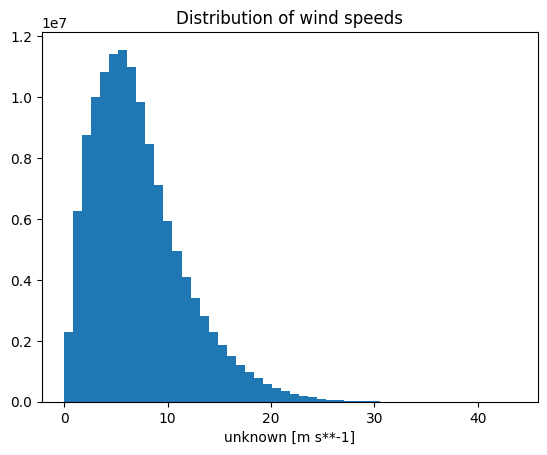

In [24]:

import matplotlib.pyplot as plt 
type(ds_final[['u100', 'v100']])
import numpy as np

def get_speed(u100, v100):
    return np.sqrt(u100*u100+v100*v100)

(fig, ax) = plt.subplots()

ds_final['wind_speed'] = get_speed(ds_final['u100'], ds_final['v100'])
# plot speeds: 


ds_final["wind_speed"].plot.hist(bins=50)

ax.set_title("Distribution of wind speeds")


Text(0.5, 1.0, 'time-averaged wind speed (2022)')

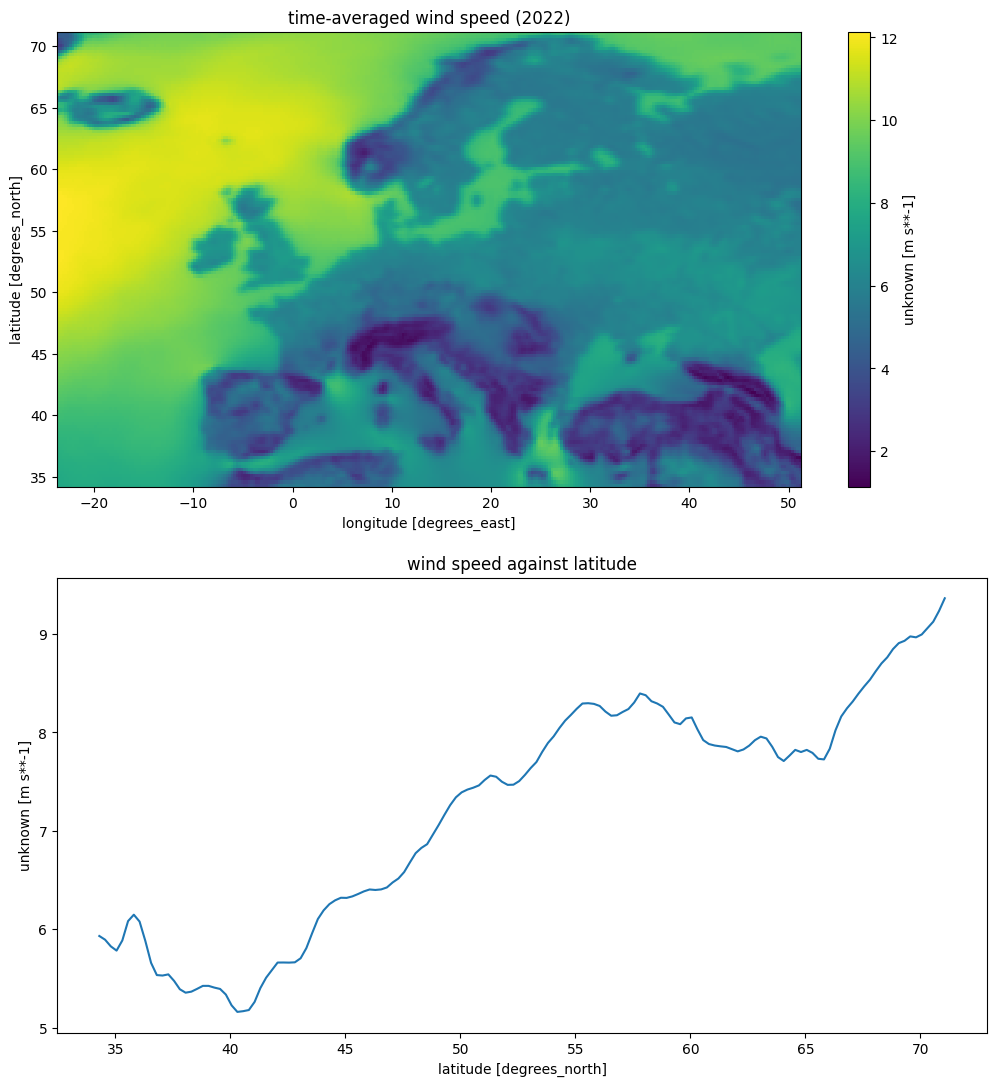

In [31]:
# it appears that wind speeds are higher at -20 than at 50
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2,1,figsize=(12,13))
ds_final["wind_speed"].mean(dim=["longitude", "valid_time"]).plot.line(ax=ax[1])

ax[1].set_title("wind speed against latitude")

ds_final.mean(dim='valid_time')['wind_speed'].plot(ax=ax[0])

ax[0].set_title("time-averaged wind speed (2022)")

Text(0.5, 1.0, 'time-averaged wind speed (2022)')

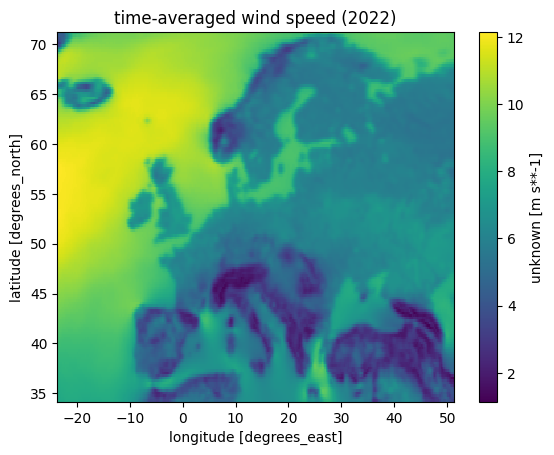

In [48]:
ds_final["cf_wind"]  = calculate_cfactor_wind(ds_final)


In [49]:
ds_final["cf_wind"].shape # (valid_time, lat, long)

(2920, 148, 300)

(array([45356769., 11952746., 11600112., 10547265.,  9126059.,  7659576.,
         6368469.,  5264315.,  4349629., 17423060.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

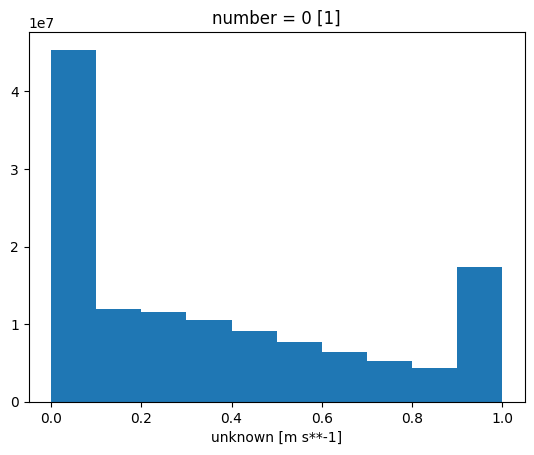

In [40]:
# VE: sanity checking capacity factor

ds_final["cf_wind"].plot()


Text(0.5, 1.0, 'time-averaged wind capacity factor (2022)')

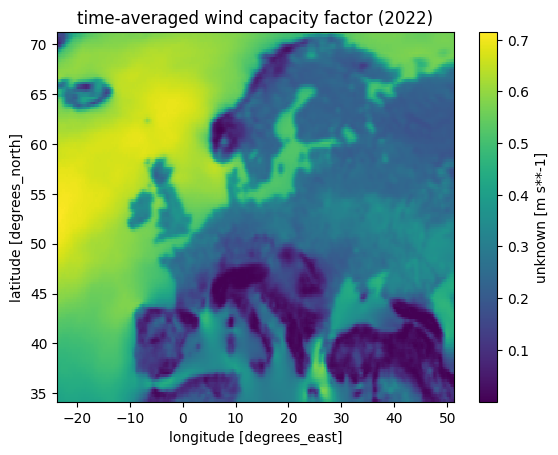

In [51]:
# let's map cf_pv
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots()

ds_final.mean(dim='valid_time')['cf_wind'].plot()

ax.set_title("time-averaged wind capacity factor (2022)")

## Exercise 3 - Plotting capacity factors for NUTS-1 regions

Your next exercise will be to plot the average capacity factor for both solar PV systems and wind energy installations of every NUTS-1 region in Europe. Import the database with NUTS regions and determine the average capacity factor per region for each of the 2 technologies. Present the results using choropleth maps. Take care of the layout of the figure (readability of ticks, axis labels, figure titles, units, legend(s), comparability of figures, etc.). Use the subplot function to plot these two maps in one figure using two subplots side by side. 

Comment on the data analytic insights that can be gained from the figure. You may add as many markdown cells as needed to the notebook, to present your findings for this and subsequent exercises.  

DE9
DEA
DEB
DEC
DED
DEE
ES2
ES3
ES4
PL4
PL5
PL6
PL7
PL8
ES5
ES6
ES7
PL9
PT1
PT2
PT3
RO1
RO2
RO3
RO4
RS1
RS2
FI1
FI2
FR1
FRB
FRC
FRD
SE1
SE2
XK0
FRE
FRF
FRG
FRH
FRI
SE3
SI0
FRJ
FRK
FRL
FRM
SK0
TR1
TR2
TR3
FRY
HR0
TR4
TR5
TR6
HU1
HU2
HU3
IE0
TR7
TR8
TR9
TRA
IS0
ITC
ITF
TRB
TRC
ITG
ITH
ITI
LI0
LT0
LU0
LV0
ME0
MK0
MT0
NL1
DEF
DEG
DK0
NL2
NL3
NL4
EE0
EL3
AL0
AT1
AT2
AT3
BA0
EL4
BE1
BE2
BE3
BG3
BG4
EL5
CH0
CY0
CZ0
DE1
EL6
ES1
NO0
PL2
DE2
DE3
DE4
DE5
DE6
DE7
DE8


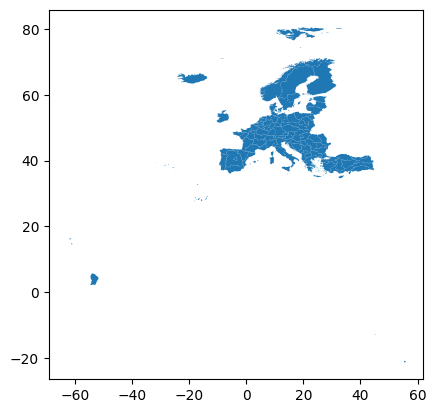

In [48]:
# import database with NUTS regions:
import geopandas as gpd
from pathlib import Path
gdf = gpd.read_file(Path("../week5/data/NUTS_RG_10M_2024_4326.geojson"))
gdf_nuts1 = gdf[gdf["LEVL_CODE"] == 1]

gdf_nuts1.plot()

for id in gdf_nuts1["NUTS_ID"]:
    print(id)


In [53]:
from shapely.geometry import mapping

#  write to files
# big_region = df_nl.iloc[:12]
for region_id in gdf_nuts1["NUTS_ID"]:
    region = gdf_nuts1[gdf_nuts1["NUTS_ID"] == region_id].copy()
    clipped_era5 = ds_final.rio.clip(region.geometry.apply(mapping), region.crs, drop=True, all_touched=True)
    # write to file? 

    # understand the no data in bounds error? 
    clipped_era5.to_netcdf(f'clipped_nuts/net_cdf_file_{region_id}.nc')
# clipped_era5['t2m'].sel(valid_time=datetime(2022,12,2, 19, 0,0)).plot()

NameError: name 'gdf_nuts1' is not defined

In [68]:

means= []
# this will only work if all files have been written to 
for region_id in gdf_nuts1["NUTS_ID"]:
    era5 = xr.open_dataset(f'clipped_nuts/net_cdf_file_{region_id}', engine="netcdf4")
    era5["cf_pv"].mean()
    # write to file? 


FileNotFoundError: [Errno 2] No such file or directory: '/Users/victorelgersma/dev/DAFS/final_assignment/clipped_nuts/net_cdf_file_ES7'

In [61]:
#insert your code for determining capacity factors per region here


In [62]:
#insert your code for plotting the capacity factor maps here


## Exercise 4 - Comparing solar PV and wind profiles of different regions

In the fourth exercise of this assignment, we want to compare the wind power and solar PV power profiles over time between the different NUTS-1 regions.

As a first step, we need to determine the average wind and solar capacity factors for every NUTS-1 region for every 3-hour timestep of the year. To do this, it is recommended to create a pandas dataframe with every timestep as the index, and the specific NUTS-1 region as a column name.

**Note:** Running this script will take long. Hence, it is highly recommended to save the dataframes you created so you can read them later from a file, without having to re-run the script.

Please provide a detailed explanation of how you approached this, the developed code as well as a summary of the created pandas data frame (number of lines, number of columns and average values per column; are these in the same range as in exercise 3?). Explain how you checked that your results are accurate. 

In [63]:
#insert code here


As a second step, you will deep-dive into one specific NUTS-1 region (not located in the Netherlands and not the same one as other groups). Create a bar plot showing the average capacity factor for every month for wind turbines and PV panels for your selected region. Present the capacity factors for both technologies in one figure. You can use the dataframe created above for this exercise, for instance using the [_resample_-function.](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)  Please provide the developed code and an explanation of your figure. Do the values presented in the figure make physical/technical sense? Justify your statements.

In [ ]:
#insert code here


As a third step, using the pandas dataframe with the average wind and PV capacity factors per time step and region created under step 1, determine the correlation of the **three-hourly values** of each of the two considered capacity factors between your selected NUTS-1 region and all other NUTS-1 regions. Plot the results.

Please provide the developed code and choropleth maps showing the correlations for the PV capacity factor and another one showing the correlations for the wind power capacity factor.  

**Note:** you will be required to use Python functions that we did not introduce before in this course! Use Google and the Python library documentation to find relevant functions.

In [ ]:
#insert code here


Q4.1. In the cell below, shortly discuss your observations based on the plots you created. What trends do you observe, and what causes these trends?

In [ ]:
#provide answer here

Subsequently, repeat the third step using the **weekly** average values for every NUTS-1 region, instead of for the 3-hourly values. Again, plot your results for the solar PV and wind correlations between your selected NUTS-1 region and all other regions in Europe.

Please provide the developed code and the choropleth maps also in this case.

In [ ]:
#insert code here


Q4.2. What differences do you observe between the plots based on the 3-hourly values and weekly average values? Discuss the main findings, and explain what causes them.

In [ ]:
#provide answer here

Q4.3. Explain why graphs showing the correlations in wind and solar energy production patterns are relevant for policy makers to provide insights into energy system design in case of high penetration of renewable energy.

In [ ]:
#provide answer here

## Exercise 5 - Modelling RES droughts

One of the main challenges for a fully-renewable based energy system is the concept of renewable energy droughts (often referred to as _Dunkelflaute_, _Dark Doldrums_ or _RES Drought_), which are moments at which there is simultaneously no or little solar **and** wind power generation. 

In this exercise, we are going to identify the share of time with a RES drought for every NUTS-1 region in mainland Europe, starting with the dataframe of the 3-hourly solar and wind generation per NUTS-1 region you created and saved earlier. 

To continue, you can assume either one of the following two simplified definitions for a period with a renewable energy drought for a specific region: 
*  Definition 1: A time period during which **both** capacity factors for wind turbines and PV panels are in the **lowest 10% quantile in the considered dataset** for the considered NUTS-1 region, _or_
*  Definition 2: A time period  during which **both** capacity factors for wind turbines and PV panels are **below 10% of their respective nominal capacity**.

Specify which definition you chose and justify your choice.

Determine the share of time with a RES drought in the considered dataset for each region for both a 3-hourly timeframe and a weekly timeframe. Plot the results.

Please provide the developed code and separate maps for the 3-hourly values and for the weekly values.

_Tip: To perform this analysis, it is recommended to create a new dataframe with every timestep as the index, and the different NUTS-1 regions as the columns. If a time period for a specific region experiences a renewable energy drought according to the definition above, mark it with 1. Otherwise, mark it with 0._

In [ ]:
#insert code here


Q5.1. Discuss the trends you observe in your plots. How does the difference in 3-hourly and weekly RES drought values affect the way policymakers should design their energy systems to ensure adequacy, i.e. that electricity demand can be served at all times?

In [ ]:
#provide answer here


Q5.2. Critically reflect on the presented approach to identify renewable energy droughts for NUTS-1 regions. Discuss 3-5 main shortcomings of this approach, and their impact.

In [ ]:
#provide answer here


## Exercise 6 - Clustering RES droughts

When designing our future renewable energy system for the whole Europe, policymakers will be interested in the similarities and differences in the RES drought patterns between regions. Neighboring regions in Europe are linked through interconnectors, which are used to transport electricity between the different regions. Hence, in case of a renewable energy drought, energy system adequacy may be ensured through the import of electricity from other regions.

In this exercise, we ask you to group the different NUTS-1 regions into a number of clusters with similar renewable energy drought patterns. This can be done by a method called _clustering_, in which the NUTS-1 regions can be subdivided into a predefined number of clusters with similar properties. You will need the dataframe with renewable energy drought data created in Exercise 5 to do this. Use the **3-hourly** values to create clusters.

Different clustering methods exist. Look up relevant clustering methods in the literature and find the documentation of a Python package supporting your preferred clustering method. Experiment with a number of clusters between 4-6 until the results are interpretable from an energy system perspective. Present your end result using a map displaying the different clusters. 

_Note: A commonly-used Python package for clustering is sklearn. Google for the appropriate documentation to conduct the analysis._

In [ ]:
#insert code here


Q6.1. Shortly describe what clustering method you used, why you selected this particular clustering method and how this method works to create its clusters.

In [ ]:
#provide answer here

Q6.2. What trends do you observe? Describe how policy makers could use such figures to promote an adequate European energy system design in case of high renewable energy penetration, in particular regarding investments for interconnector capacity.

In [ ]:
#provide answer here

## Open Research Question

Extend the analysis on capacity factors, correlations and renewable energy droughts, for instance by eliminating some of the shortcomings you identified in Q5.2. Or propose a new energy system related question that you are interested in. Feel free to download extra data from CDS, NEWA (New European Wind Atlas) https://map.neweuropeanwindatlas.eu/, IEA (International Energy Agency) Europe Data explorer https://www.iea.org/regions/europe, or other publicly available sources to conduct your analysis. Other suggestions include electricity demand and price data from the ENTSO-e transparency platform https://transparency.entsoe.eu/, interconnection capacities from TYNDP https://tyndp.entsoe.eu/resources, installed capacities of wind energy in Europe from https://zenodo.org/records/7558885 etc. Describe the data you used, the steps you have taken for your analysis, and present your results with attractive plots. 

In [ ]:
#provide your code, plots and analysis here, using as many code and markdown cells as necessary

# Sources

Docs:
- https://docs.xarray.dev
- https://docs.python.org/3/

What is a variable, dimension, coordinate? 
- https://www.youtube.com/watch?v=1AtfxsglBjs 

Creating a DataArray from scratch:
- https://www.youtube.com/watch?v=hiwDEjv2a60

Creating subplots:
https://www.youtube.com/watch?v=yCGfZhDzVXY

